# 趋势划分程序快速文档

#### 写在前面

对市场做定量分析是一个很多人都想做的事情，每个人都会尝试各种角度去分析市场，我也不例外，但我认为想要对市场进行分析应该首先找到一套合适的行情描述框架，我认为k线并不是一个很好的数据源，虽然k线把行情信息做了最大程度的包留，但是里面也夹杂了很多我们不需要的噪音，而我们分析市场行为核心是分析价格的变化，这时用k线对计算机来说是不友好的，于是在和麻衣哥讨论之后，我决定写出一套新的项目把行情以趋势表征，基于这样的表征方法后面无论是开展传统技术分析还是统计、或是深度学习，我认为对市场信息的利用率都是比基于k线分析更为高效的。

这里对行情层级的划分规则基于道氏理论，**每次回调都高于前一较低点、而之后会突破前一高点，这就说明这个大行情还没被打破，这些小的价格变化可以合成一个新的大趋势**

我把分钟作为最小的趋势单元，假定一分钟内只会有一次小波动，这个小波动由k线最高和最低点以一定规则转换为最底层行情

我并不是软件工程领域专业的，所以有些地方可能会显得很混乱，比如类的变量私有还是不私有，我完全是看心情写的，变量和方法的命名规范也没有很严格，如果合作者觉得很不方便可以联系我，我尽量把程序写的更清晰一些，请见谅。

其实只是完成的很粗略，还有些小功能没实现，比如框定时间范围画图，比如更改最新的一根k线而不是新加一根k线，再比如往前拓展分析区域

欢迎交流和合作，希望我的小项目能让更多人方便的做市场分析

我的个人邮箱是 yihan.yu@foxmail.com

#### 本项目类别及主要功能大纲：
 - class.timepoint.Timepoint 这是本项目中会统一用到的表征时间的变量
    - var
      - year
      - month
      - day
      - hour
      - minute
    - function
      - get_pdtimepoint()  _获得datetime可以索引的时间戳，因为主要给pd读所以我暂时命名pd_
      - previous(delta)  _把这个时间点类前移delta分钟_
      - next(delta)  _把这个时间点类后移delta分钟_
      - get_before(delta)  _获得这个时间点类前delta分钟的时间点类_
      - get_after(delta)  _获得这个时间点类后delta分钟的时间点类_
 - class.kline_client.KlineClient 项目里的功能都调用这个类的方法获得k线数据，我这里暂时调的cvs，也可以写成交易所api
    - var
      - config
    - function
      - get_kline(time:Timepoint) 获得timepoint时间点处的k线数据，以字典形式返回
 - class.trend.Trend 这是本项目最核心的类，表征行情，一个大行情可以包含小行情，小行情也可以索引到他所从属的大行情
    - var
      - begin_time 
      - end_time
      - begin_price
      - end_price
      - is_sure 本段行情是否已被确认，换句话说有没有被打破，或是仍有可能被更新
      - break_price 行情会被打破的价格，通常是前一次回调点
      - include_list 这个大行情包含的次级小行情
      - father_trend 这个行情所属的大行情，如果没有则返回None
    - function 感觉都是内部计算会用到的方法，因为没有写的很好所以调用会有危险，这里暂时不做介绍
 - class.analyse_area.AnalyseArea 这里管理分析区域，当他被创建时就会自动分析时间内所有的行情，给出大小行情的包含关系
    - var
      - begin: Timepoint  分析区域开始时间
      - end: Timepoint  分析区域结束时间
      - kline_clt  用于获得k线的Kline_client实例
      - trendlist  该区域内包含的行情，这里只储存最高级别的无法继续合成的趋势，他们自己包含的趋势由各自的include_list管理
    - function
      - synchronize(new_time： Timepoint) 更新分析区域末尾时间到new_time
 - class.plot_driver.Plot_driver 这个类的实例管画图，目前没啥复杂功能，就只是画个图，不过其实我想让他做动画，甚至生成交互式图窗
    - var
      - config
    - function
      - draw(area: AnalyseArea , layer = 3) 把area的k线和里面的趋势都画出来，layer控制从大趋势开始往下画几层

**在开始运行前，我强烈建议你先运行这个py文件获取数据源cvs，除非你写了自己的kline client**

In [ ]:
# 运行根目录下的data_download.py
# 这里为了节约时间，只下载23年到现在的数据，所以这里都是23年的演示
# 但readme里都是22年的演示，会和这个文档结果不一样
%run data_download.py

In [1]:
import classes
import importlib

importlib.reload(classes)

from classes.trend import Trend
from classes.kline_client import Kline_client
from classes.timepoint import Timepoint
from classes.plot_driver import Plot_driver
from classes.analyse_area import Analyse_area

首先生成数据源client实例

In [2]:
kline_clt = Kline_client()

然后创建一个工作区，创建的时候工作区就会把时间范围内的行情分析出来，并生成一个包含所有趋势的列表

In [3]:
area = Analyse_area(Timepoint(2023,3,5,12,31),Timepoint(2023,3,7,12,31),kline_clt)

这时就已经可以看到工作区下管理了几段趋势

In [4]:
for item in area.trendlist:
    print(item)

2022-03-05 12:31 to 2022-03-05 12:40, 39206.01 to 39371.15
2022-03-05 12:40 to 2022-03-05 13:36, 39371.15 to 38889.75
2022-03-05 13:36 to 2022-03-06 00:59, 38889.75 to 39693.87
2022-03-06 00:59 to 2022-03-07 03:15, 39693.87 to 37578.03
2022-03-07 03:15 to 2022-03-07 12:21, 37578.03 to 38723.68
2022-03-07 12:21 to 2022-03-07 12:22, 38723.68 to 38588.98
2022-03-07 12:22 to 2022-03-07 12:25, 38588.98 to 38717.79
2022-03-07 12:25 to 2022-03-07 12:31, 38717.79 to 38612.95


每段趋势也可以去查询他下面管理的子趋势

In [5]:
print(area.trendlist[4])
for item in area.trendlist[4].include_list:
    print('|-',item)

2022-03-07 03:15 to 2022-03-07 12:21, 37578.03 to 38723.68
|- 2022-03-07 03:15 to 2022-03-07 05:21, 37578.03 to 38247.48
|- 2022-03-07 05:21 to 2022-03-07 08:32, 38247.48 to 37649.46
|- 2022-03-07 08:32 to 2022-03-07 09:07, 37649.46 to 38394.21
|- 2022-03-07 09:07 to 2022-03-07 11:00, 38394.21 to 37970.73
|- 2022-03-07 11:00 to 2022-03-07 12:21, 37970.73 to 38723.68


当然也可以反查父趋势

In [6]:
print(area.trendlist[4])
print(area.trendlist[4].include_list[2].father_trend)

2022-03-07 03:15 to 2022-03-07 12:21, 37578.03 to 38723.68
2022-03-07 03:15 to 2022-03-07 12:21, 37578.03 to 38723.68


还可以创建一个plotdriver画出工作区和工作区里的趋势

这里趋势的层级用颜色的深浅表示，最上层的大趋势是颜色最深的，每个趋势所包含的小趋势就会比他颜色更浅一点

趋势是否被确认由蓝色和红色区分
蓝色表示趋势已经确认了，后面不会再变了，一般是已经被打破或者超越了。
红色表示趋势还没确认，后面还有可能被更新，一般表示还没被打破，后面还可能被延续

c:\Users\ASUS\anaconda3\Lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


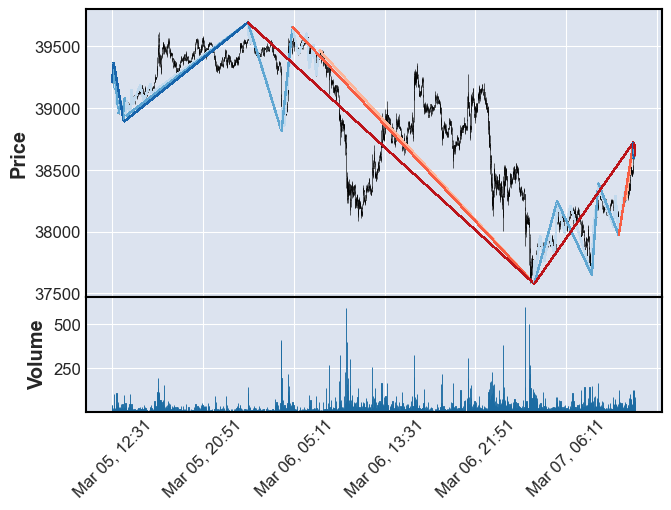

In [7]:
pds = Plot_driver(kline_clt)
pds.draw(area,layer = 3)

把layer改大和改小可以改变画出趋势的层数

c:\Users\ASUS\anaconda3\Lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


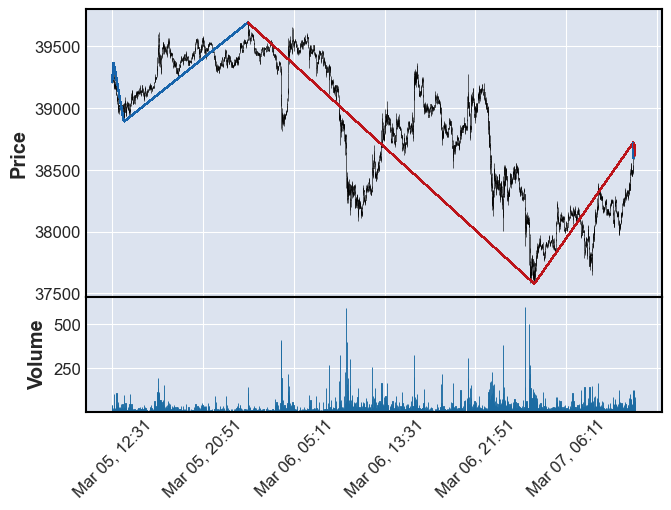

In [8]:
pds.draw(area,layer = 1)

c:\Users\ASUS\anaconda3\Lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


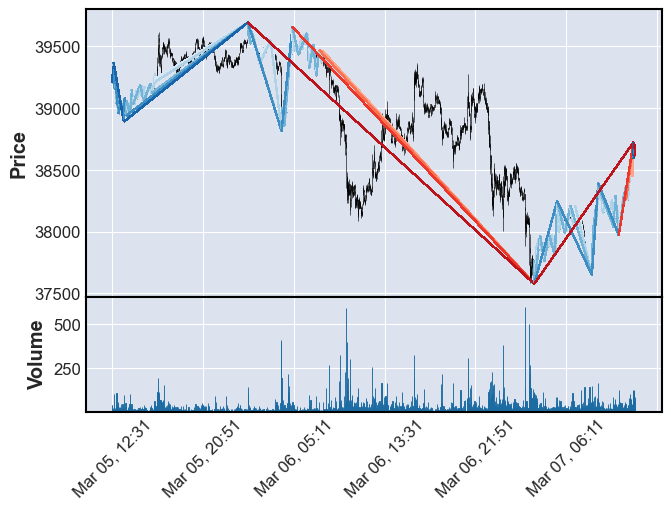

In [9]:
pds.draw(area,layer = 5)

如果这时候你觉得行情更新了，想往后继续分析，可以用synchronize方法，他会把分析区域末尾时间更新到最新的行情时间，然后我们重新画图就能看到变化

c:\Users\ASUS\anaconda3\Lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


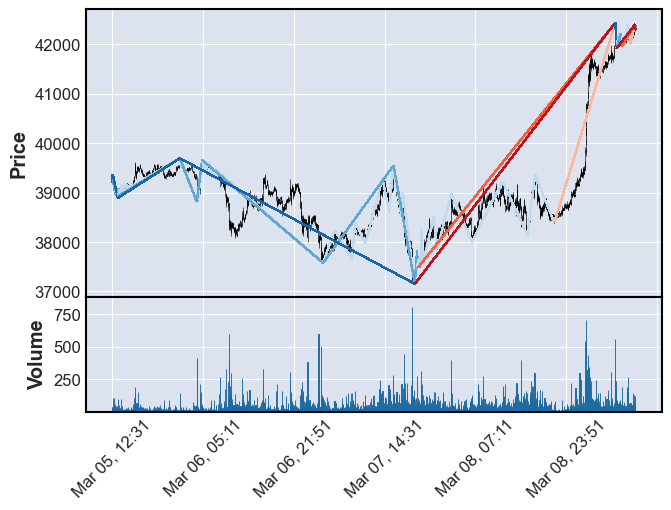

In [10]:
area.synchronize(Timepoint(2023,3,9,12,31))
pds.draw(area,layer = 3)

你也可以逐步增加时间点，看行情是怎么一点点生成出来的

In [11]:
begin = Timepoint(2023,3,5,12,31)
point = begin.get_after(1)
small_area = Analyse_area(begin,point,kline_clt)
pds = Plot_driver(kline_clt)

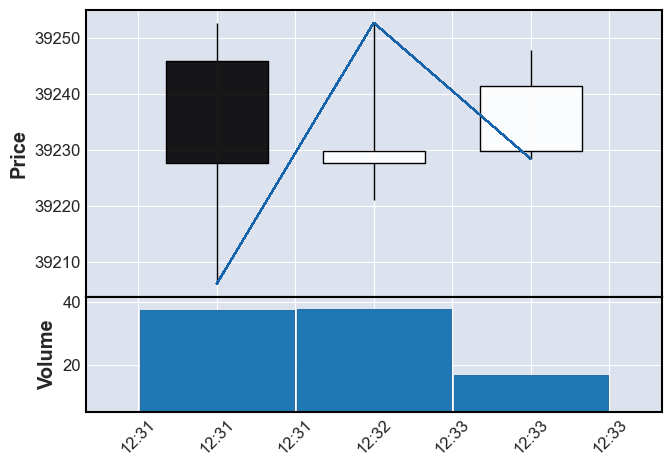

In [12]:
#<-每次运行都会更新区域的时间
point.next()
small_area.synchronize(point)
pds.draw(small_area,layer = 5)